# MS-AAI-501: Intro to AI
## Final Project:  Airline Flight Delay Analysis and Modeling
### File Name:  Data Exploration.jpynb
### Date:  12/4/2023
### Author:  Ned Kost


In [22]:
# Import libraries to explore dataset
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from matplotlib.pyplot import figure
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import t

# Turn off Warnings
warnings.filterwarnings("ignore")


# Setup Dataset

In [13]:
# Import 3 years of flight data
all_flights_df = pd.read_csv('../data/all_flight_data.csv')
all_flights_df.head()

# Filter out Delayed and Cancelled flights
flights_df = all_flights_df[(all_flights_df['Cancelled'] == 0) & (all_flights_df['Diverted'] == 0)]

# Calculated Features
#  1) Calculate Delayed based on ArrDel15
flights_df['Delayed'] = flights_df['ArrDel15'].apply(lambda x: 1 if x > 0 else 0 )

#  2) Flights in a day by grouping on Tail_Number and FlightDate
### TODO - Use Tail_number, FlightDate, and Deptime

#  2) Departure Tarmac Time
flights_df['DepTarmacTime'] = flights_df['WheelsOff'] - flights_df['DepTime']

#  3) Arrival Tarmac Time
flights_df['ArrTarmacTime'] = flights_df['ArrTime'] - flights_df['WheelsOn']

#  4) Calculate Employees Per Monthly Flight Count (Grand Total / Monthly Flights)
## Group flight dataset by Tail_Number
flightCount_df = pd.DataFrame(flights_df.groupby(['Carrier', 'Year', 'Month'])['Carrier'].count())
flightCount_df.rename(columns={'Carrier': 'MonthlyFlights'}, inplace=True)
flightCount_df = flightCount_df.reset_index()

## Merge Monthly flight count and calculate EmpPerMF
flights_df = pd.merge(flights_df, flightCount_df, how='left', left_on=['Carrier', 'Year', 'Month'], right_on=['Carrier', 'Year', 'Month'])
flights_df['EmpPerMF'] = flights_df['Grand Total'] / flights_df['MonthlyFlights']
flights_df['TaxiWheelsOut'] = flights_df['WheelsOff'] - flights_df['DepTime']

# Get rid of Destination that had only 1 Flight that was delayed (Outlier?)
flights_df = flights_df[flights_df['Dest'] != 'IFP']

In [3]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16809808 entries, 0 to 16809808
Data columns (total 43 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Year                             int64  
 1   Quarter                          int64  
 2   Month                            int64  
 3   DayofMonth                       int64  
 4   DayOfWeek                        int64  
 5   FlightDate                       object 
 6   Reporting_Airline                object 
 7   Tail_Number                      object 
 8   Flight_Number_Reporting_Airline  int64  
 9   Origin                           object 
 10  Dest                             object 
 11  DepTime                          float64
 12  DepDelay                         float64
 13  TaxiOut                          float64
 14  WheelsOff                        float64
 15  WheelsOn                         float64
 16  TaxiIn                           float64
 17  CRSArr

# Explore Statistics on Dataset

## Flights by Time factors

In [14]:
# Divide flights dataset into Delayed and Ontime flights
delayed_df = flights_df[flights_df['Delayed'] ==1] 
ontime_df = flights_df[flights_df['Delayed'] == 0] 

# Output % of flights delayed
print('Percentage of flights that are delayed: %.2f%%' % (len(delayed_df)/len(flights_df) * 100))

Percentage of flights that are delayed: 16.77%


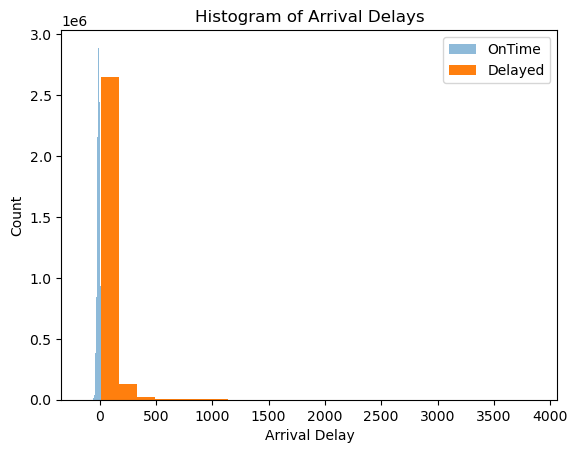

Extremely right skewed arrival delay for flights with a large departure delay.


In [6]:
# Departure Time analysis
plt.hist(ontime_df['ArrDelay'], bins=24, alpha=.5)
plt.hist(delayed_df['ArrDelay'], bins=24)
plt.legend(['OnTime', 'Delayed'])
plt.xlabel('Arrival Delay')
plt.ylabel('Count')
plt.title('Histogram of Arrival Delays')
plt.show()
print('Extremely right skewed arrival delay for flights with a large departure delay.')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


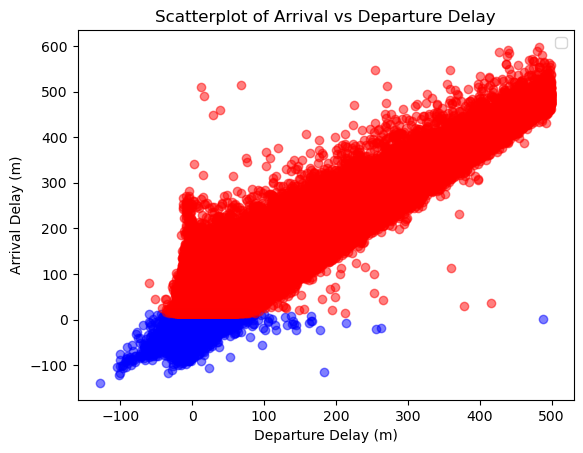

In [11]:
filtered_delay_df = delayed_df[delayed_df['DepDelay'] < 500]

# Display Scatterplot of Arrival Delay vs. Departuer Delay
plt.scatter(ontime_df['DepDelay'], ontime_df['ArrDelay'], color='blue', alpha=.5)
plt.scatter(filtered_delay_df['DepDelay'], filtered_delay_df['ArrDelay'], color='red', alpha=.5)
plt.xlabel('Departure Delay (m)')
plt.ylabel('Arrival Delay (m)')
plt.legend(['Ontime','Delayed'])
plt.title('Scatterplot of Arrival vs Departure Delay')
plt.show()


In [28]:
# Function to calculate Confidence Interval when comparing two sample means
#   y1 = Dataset 1
#   y2 = Dataset 2
#   equal_var = Whether or not to assume the two samples standard deviations are roughly equal
#   alpha var = 1 - desired confidence level
def t2ind_confint(y1, y2, equal_var = True, alpha = .05):
    n1 = len(y1)
    n2 = len(y2)
    v1 = np.var(y1)*n1/(n1-1)
    v2 = np.var(y2)*n2/(n2-1)
    if equal_var:
        df = n1 + n2 - 2
        vardiff = ((n1-1)*v1 + (n2-1)*v2) / (df) * (1/n1 + 1/n2)
    else:
        df = (v1/n1 + v2/n2)**2 / (v1**2/(n1**2*(n1-1)) + v2**2/(n2**2*(n2-1)))
        vardiff = v1/n1 + v2/n2
    se = np.sqrt(vardiff)
    qt = t.ppf(1-alpha/2, df)     # t quartile for 100(1-alpha)% CI
    mean_diff = np.mean(y1) - np.mean(y2)
    confint = mean_diff + np.array([-1, 1])*qt*se
    conf = 1 - alpha
    return mean_diff, confint, conf, df

# Output standard deviation of Delayed vs Ontime flights
print('std of Departure Delay for Delayed Flights: %.4f' % delayed_df['DepDelay'].std())
print('std of Departure Delay for Ontime Flights: %.4f' % ontime_df['DepDelay'].std())

print('Mean of Departure Delay for Delayed Flights: %.4f' % delayed_df['DepDelay'].mean())
print('Mean of Departure Delay for Ontime Flights: %.4f' % ontime_df['DepDelay'].mean())


# Calculate Confidendce Intervale for difference between two means 
mean_diff, confint, conf, df = t2ind_confint(delayed_df['DepDelay'], ontime_df['DepDelay'], False)
                                                       
print('The difference between departure delay for On-Time and Delayed flights is between: \n(', round(confint[0],2),',',round(confint[1],2), ')')
print('The Departure Delay for Delayed flights is 64 minutes larger than Ontime flights 95% of the time.')

std of Departure Delay for Delayed Flights: 96.9451
std of Departure Delay for Ontime Flights: 7.4445
Mean of Departure Delay for Delayed Flights: 62.4619
Mean of Departure Delay for Ontime Flights: -2.1779
The difference between departure delay for On-Time and Delayed flights is between: 
( 64.53 , 64.75 )
The Departure Delay for Delayed flights is 64 minutes larger than Ontime flights 95% of the time.


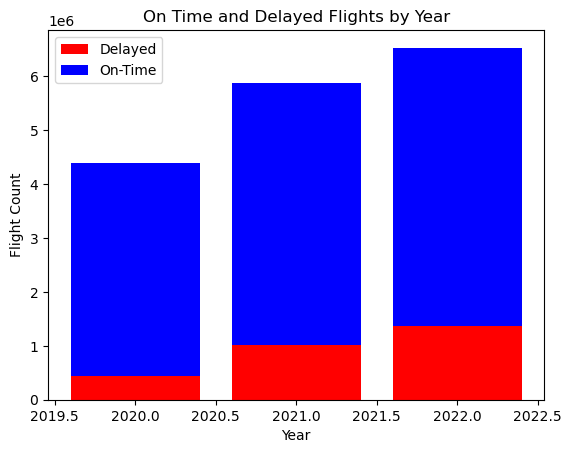

Delayed flight count goes up year over year, along with total flight count.  
2020 had fewer proportional delays than later months.
Year is unlikely to be a relevant feature since you can not use year to predict future delays


In [91]:
# Group flight dataset by Year
yearly_df = pd.DataFrame(flights_df.groupby(['Year', 'Delayed'])['Year'].count())
yearly_df.rename(columns={'Year': 'Count'}, inplace=True)
yearly_df = yearly_df.reset_index()

# Create graphing data
d = yearly_df[yearly_df['Delayed'] == 1]
f = yearly_df[yearly_df['Delayed'] == 0]

# Plot Delayed and On-Time flights by Year
plt.bar(d['Year'], d['Count'], color='r')
plt.bar(f['Year'], f['Count'], bottom=d['Count'], color='b')
plt.xlabel('Year')
plt.ylabel('Flight Count')
plt.legend(['Delayed', 'On-Time'])
plt.title('On Time and Delayed Flights by Year')
plt.show()

print('Delayed flight count goes up year over year, along with total flight count.  \n2020 had fewer proportional delays than later months.')
print('Year is unlikely to be a relevant feature since you can not use year to predict future delays')

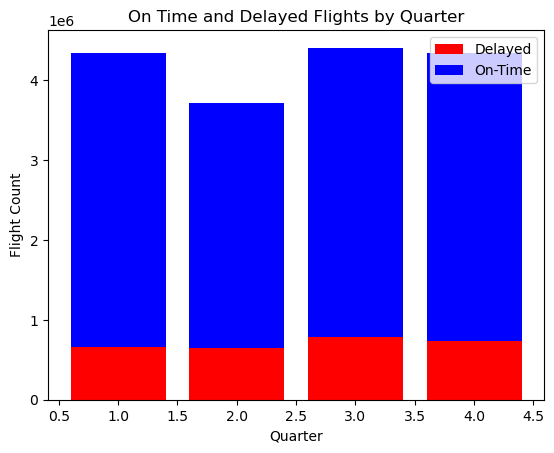

In [98]:
# Group flight dataset by Month
quarterly_df = pd.DataFrame(flights_df.groupby(['Quarter', 'Delayed'])['Quarter'].count())
quarterly_df.rename(columns={'Quarter': 'Count'}, inplace=True)
quarterly_df = quarterly_df.reset_index()

# Create graphing data
q = quarterly_df[quarterly_df['Delayed'] == 1]
f = quarterly_df[quarterly_df['Delayed'] == 0]

# Plot Delayed and On-Time flights by Month
plt.bar(q['Quarter'], q['Count'], color='r')
plt.bar(f['Quarter'], f['Count'], bottom=q['Count'], color='b')
plt.xlabel('Quarter')
plt.ylabel('Flight Count')
plt.legend(['Delayed', 'On-Time'])
plt.title('On Time and Delayed Flights by Quarter')
plt.show()

# Print findings
print('Delayed flights are roughly uniform across quarter.  This is likely not a good feature to use for modeling.')

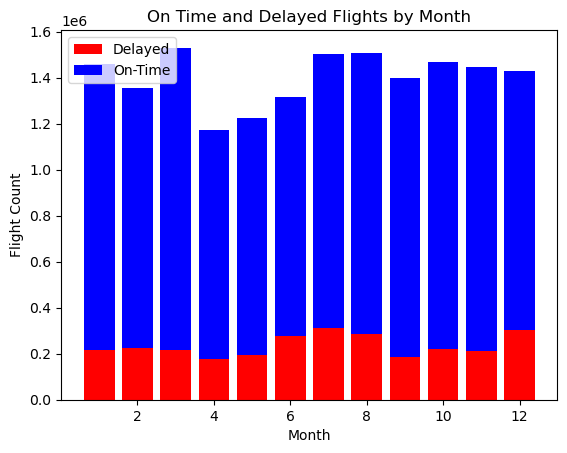

Delayed flights loosely follow total flight trends, but with higher spikes during summer months and December.
Interesting note:  January has more flights, but fewer delayed than December.
Month is likely a good feature for detecting delays due to varaince by Month.


In [101]:
# Group flight dataset by Month
monthly_df = pd.DataFrame(flights_df.groupby(['Month', 'Delayed'])['Month'].count())
monthly_df.rename(columns={'Month': 'Count'}, inplace=True)
monthly_df = monthly_df.reset_index()

# Create graphing data
m = monthly_df[monthly_df['Delayed'] == 1]
f = monthly_df[monthly_df['Delayed'] == 0]

# Plot Delayed and On-Time flights by Month
plt.bar(m['Month'], m['Count'], color='r')
plt.bar(f['Month'], f['Count'], bottom=m['Count'], color='b')
plt.xlabel('Month')
plt.ylabel('Flight Count')
plt.legend(['Delayed', 'On-Time'])
plt.title('On Time and Delayed Flights by Month')
plt.show()

# Print findings
print('Delayed flights loosely follow total flight trends, but with higher spikes during summer months and December.')
print('Interesting note:  January has more flights, but fewer delayed than December.')
print('Month is likely a good feature for detecting delays due to varaince by Month.')

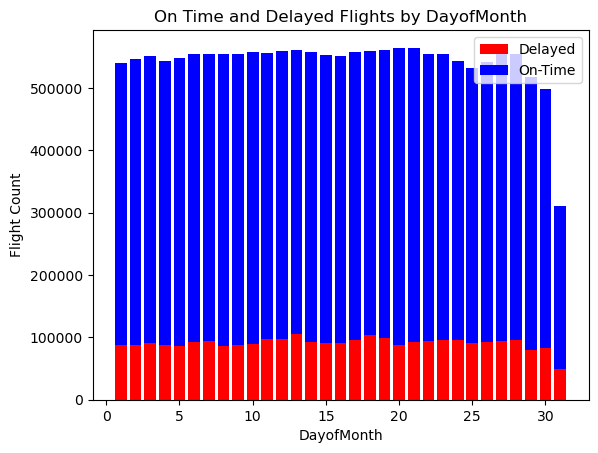

In [102]:
# Group flight dataset by DayofMonth
dom_df = pd.DataFrame(flights_df.groupby(['DayofMonth', 'Delayed'])['DayofMonth'].count())
dom_df.rename(columns={'DayofMonth': 'Count'}, inplace=True)
dom_df = dom_df.reset_index()

# Create graphing data
d = dom_df[dom_df['Delayed'] == 1]
f = dom_df[dom_df['Delayed'] == 0]

# Plot Delayed and On-Time flights by Month
plt.bar(d['DayofMonth'], d['Count'], color='r')
plt.bar(f['DayofMonth'], f['Count'], bottom=d['Count'], color='b')
plt.xlabel('DayofMonth')
plt.ylabel('Flight Count')
plt.legend(['Delayed', 'On-Time'])
plt.title('On Time and Delayed Flights by DayofMonth')
plt.show()

print('Delayed flights across Day of Month is roughly uniform.  There are a couple small spikes around the 13th, and the 18th.')
print('The 31st logically has fewer delays since there are fewer flights.')
print('Overall there is likely a weak correlation between delays and Day of Month.')


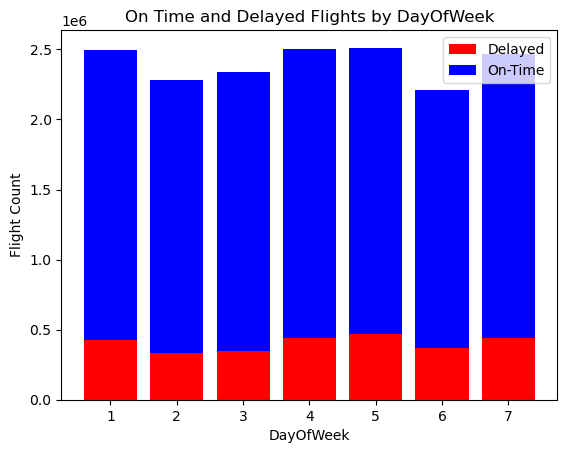

Delayed,0,1
DayOfWeek,,
1,0.830443,0.169557
2,0.855590,0.144410
3,0.851816,0.148184
4,0.822644,0.177356
5,0.813634,0.186366
6,0.833654,0.166346
7,0.821659,0.178341


In [152]:
# Group flight dataset by DayOfWeek
dow_df = pd.DataFrame(flights_df.groupby(['DayOfWeek', 'Delayed'])['DayOfWeek'].count())
dow_df.rename(columns={'DayOfWeek': 'Count'}, inplace=True)
dow_df = dow_df.reset_index()

# Create graphing data
d = dow_df[dow_df['Delayed'] == 1]
f = dow_df[dow_df['Delayed'] == 0]

# Plot Delayed and On-Time flights by Month
plt.bar(d['DayOfWeek'], d['Count'], color='r')
plt.bar(f['DayOfWeek'], f['Count'], bottom=d['Count'], color='b')
plt.xlabel('DayOfWeek')
plt.ylabel('Flight Count')
plt.legend(['Delayed', 'On-Time'])
plt.title('On Time and Delayed Flights by DayOfWeek')
plt.show()

# Cross tab report for Day of Week
dow_crosstab_df = pd.crosstab(flights_df['DayOfWeek'],flights_df['Delayed'],normalize='index')
display(dow_crosstab_df)

# Output findings
print('Delayed flights loosely follow total flights, with a small spikes on Thursday and Saturday.')
print('There is likely a weak correlation between Day of Week and Delayed.')

count    1.680981e+07
mean     1.325698e+03
std      4.909314e+02
min      1.000000e+00
25%      9.190000e+02
50%      1.319000e+03
75%      1.731000e+03
max      2.400000e+03
Name: DepTime, dtype: float64

count    2.819051e+06
mean     1.510146e+03
std      4.957309e+02
min      1.000000e+00
25%      1.141000e+03
50%      1.551000e+03
75%      1.916000e+03
max      2.400000e+03
Name: DepTime, dtype: float64

count    1.399076e+07
mean     1.288533e+03
std      4.814803e+02
min      1.000000e+00
25%      8.560000e+02
50%      1.249000e+03
75%      1.702000e+03
max      2.400000e+03
Name: DepTime, dtype: float64

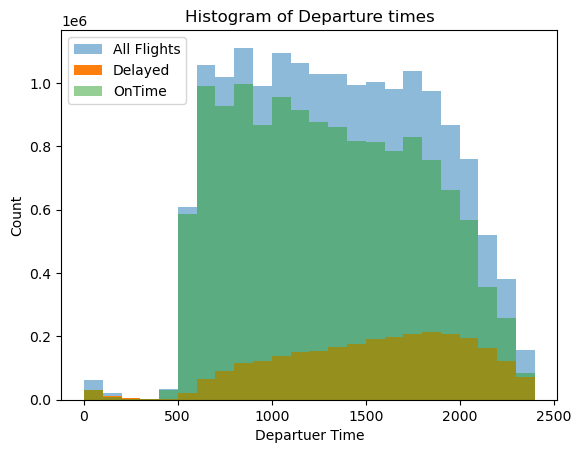

Departure Time looks like a good feature with the left skewed histogram pointing to an increased likelihood of flights later in the day being delayed.


In [229]:
# Departure Time analysis
display(flights_df['DepTime'].describe())
display(delayed_df['DepTime'].describe())
display(ontime_df['DepTime'].describe())

plt.hist(flights_df['DepTime'], bins=24, alpha=.5)
plt.hist(delayed_df['DepTime'], bins=24)
plt.hist(ontime_df['DepTime'], bins=24, alpha=.5)
plt.legend(['All Flights', 'Delayed', 'OnTime'])
plt.xlabel('Departuer Time')
plt.ylabel('Count')
plt.title('Histogram of Departure times')
plt.show()

# Output Analysis
print('Departure Time looks like a good feature with the left skewed histogram pointing to an increased likelihood of flights later in the day being delayed.')

## Flights by Carrier Info
- AA: American Airlines
- AS: Alaska Airlines
- B6: JetBlue
- DL: Delta Airlines
- EV: Express Jet
- F9: Frontier Airlines
- G4: Allegiant Air
- HA: Hawaiian Airlines
- MQ: American Eagle Airlines
- NK: Spirit
- OH: PSA Airlines
- OO: SkyWest
- QX: Horizon Air
- UA: United Airelines
- WN: Southwestern Airlines
- YV: Mesa Airlines
- YX: Republic Airlines
- 9E: Endeavor

Delayed,0,1
Reporting_Airline,,
WN,2589850,593189
AA,1723169,375208
OO,1732601,294242
DL,1895821,275937
UA,1115977,221829
B6,441473,154840
YX,713890,122337
NK,433405,108806
MQ,583735,107260


Delayed,0,1
Reporting_Airline,,
G4,0.725560,0.274440
B6,0.740338,0.259662
F9,0.763923,0.236077
NK,0.799329,0.200671
WN,0.813641,0.186359
AA,0.821191,0.178809
YV,0.822931,0.177069
AS,0.829362,0.170638
UA,0.834184,0.165816


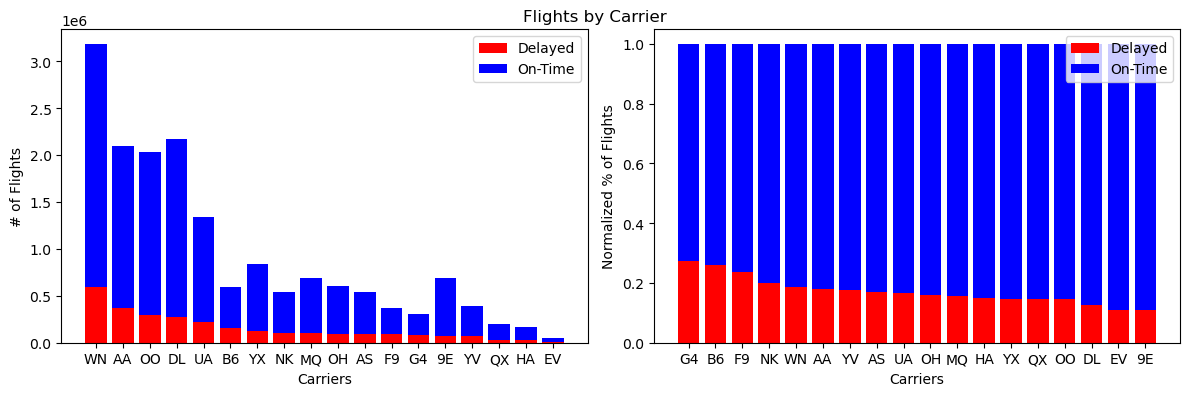

Top 3 Airlines with Delayed Flights (count): Southwestern Airlines, American Airlines, SkyWest
Top 3 Airlines with Delayed Flights (%): Allegiant Air, JetBlue, Frontier Airlines
Carrier looks like a good feature with 


In [172]:
# Cross tab report for Carrier
airline_crosstab_df = pd.crosstab(flights_df['Reporting_Airline'],flights_df['Delayed'])
# Sort by percentage of collissions that result in fatality
airline_crosstab_df.sort_values(airline_crosstab_df.columns[1], ascending = False, inplace=True)
display(airline_crosstab_df)

# Cross tab report for Day Carrier
norm_airline_crosstab_df = pd.crosstab(flights_df['Reporting_Airline'],flights_df['Delayed'], normalize='index')
norm_airline_crosstab_df.sort_values(norm_airline_crosstab_df.columns[1], ascending = False, inplace=True)
display(norm_airline_crosstab_df)

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(12,4))

# Set Data for Delays by Airline Carrier
y1 = airline_crosstab_df[1]
y2 = airline_crosstab_df[0]
x = airline_crosstab_df.index

# Plot Delayed flights by Airline Carrier
ax1 = fig.add_subplot(gs[0])
ax1.bar(x, y1, color='r')
ax1.bar(x, y2, bottom=y1, color='b')
ax1.set_xlabel('Carriers')
ax1.set_ylabel('# of Flights')
ax1.legend(['Delayed', 'On-Time'])

# Set Data Delayed flights by Normalized Airline Carrier data
y1 = norm_airline_crosstab_df[1]
y2 = norm_airline_crosstab_df[0]
x = norm_airline_crosstab_df.index

# Plot Delayed flights by Normalzied Airlined Carrier data
ax2 = fig.add_subplot(gs[1])
ax2.bar(x, y1, color='r')
ax2.bar(x, y2, bottom=y1, color='b')
ax2.set_xlabel('Carriers')
ax2.set_ylabel('Normalized % of Flights')
ax2.legend(['Delayed', 'On-Time'])

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Flights by Carrier')
fig.subplots_adjust(top=.93)
plt.show()

# Output findings
print('Top 3 Airlines with Delayed Flights (count): Southwestern Airlines, American Airlines, SkyWest')
print('Top 3 Airlines with Delayed Flights (%): Allegiant Air, JetBlue, Frontier Airlines')
print('Carrier looks like a good feature interesting variations across airline carrier. ')


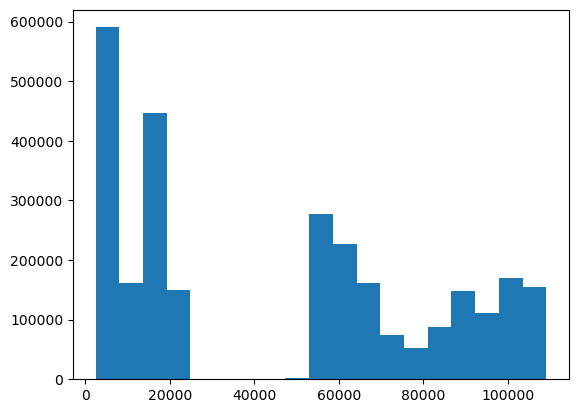

In [186]:
# TODO: Analyze Delays by Carrier employees

# For Each Airline, create a histogram with carrier employees

plt.hist(delayed_df['Grand Total'], bins=19)
plt.show()

count    16761828.000000
mean            0.929230
std             0.790529
min             0.187552
25%             0.314346
50%             0.711560
75%             1.312322
max            11.958720
Name: EmpPerMF, dtype: object

count    2813736.000000
mean           0.866920
std            0.623913
min            0.187552
25%            0.433615
50%            0.638195
75%            1.250000
max           11.958720
Name: EmpPerMF, dtype: object

count    13948092.000000
mean            0.941800
std             0.819473
min             0.187552
25%             0.304105
50%             0.725071
75%             1.341451
max            11.958720
Name: EmpPerMF, dtype: object

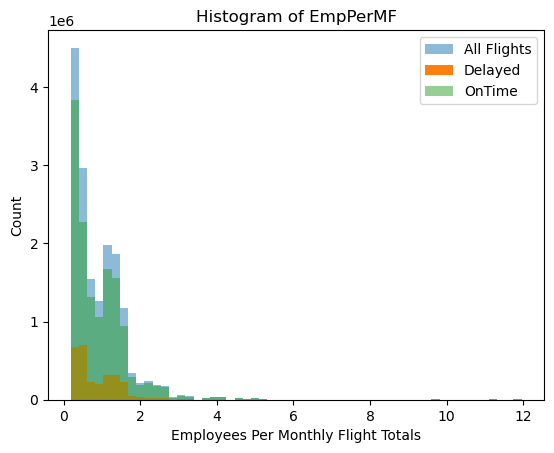

The smaller medium hints at a potential imapct employee count has on delayed flights.


In [270]:
# Departure Time analysis
display(flights_df['EmpPerMF'].describe().apply(lambda x: format(x, 'f')))
display(delayed_df['EmpPerMF'].describe().apply(lambda x: format(x, 'f')))
display(ontime_df['EmpPerMF'].describe().apply(lambda x: format(x, 'f')))

plt.hist(flights_df['EmpPerMF'], bins=55, alpha=.5)
plt.hist(delayed_df['EmpPerMF'], bins=55)
plt.hist(ontime_df['EmpPerMF'], bins=55, alpha=.5)
plt.legend(['All Flights', 'Delayed', 'OnTime'])
plt.xlabel('Employees Per Monthly Flight Totals')
plt.ylabel('Count')
plt.title('Histogram of EmpPerMF')
plt.show()

print('The smaller medium hints at a potential imapct employee count has on delayed flights.')

# Flights By Airport (orig & dest)

Delayed,0,1
Origin,,
DFW,604224,148075
DEN,560487,145397
ATL,745919,119874
ORD,549866,116206
CLT,456917,88740
...,...,...
FLO,98,11
IPT,65,6
BFM,35,5


Delayed,0,1
Origin,,
CDB,0.475000,0.525000
ADK,0.570934,0.429066
PPG,0.584158,0.415842
ILG,0.594937,0.405063
HTS,0.652941,0.347059
...,...,...
PGV,0.928571,0.071429
PIH,0.934143,0.065857
CDC,0.935308,0.064692


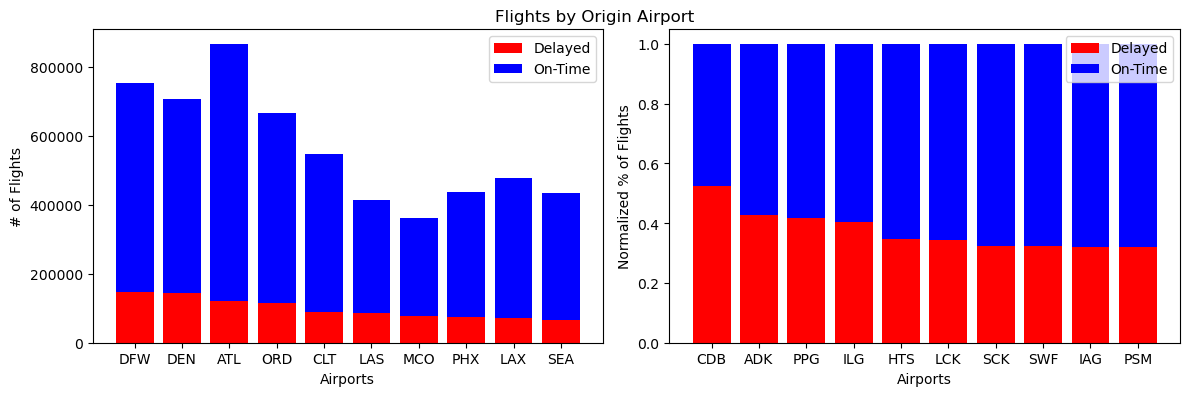

In [191]:
# Cross tab report for Origin Airport
airport_crosstab_df = pd.crosstab(flights_df['Origin'],flights_df['Delayed'])
# Sort by percentage of collissions that result in fatality
airport_crosstab_df.sort_values(airport_crosstab_df.columns[1], ascending = False, inplace=True)
display(airport_crosstab_df)

# Cross tab report for Origin Airport
norm_airport_crosstab_df = pd.crosstab(flights_df['Origin'],flights_df['Delayed'], normalize='index')
norm_airport_crosstab_df.sort_values(norm_airport_crosstab_df.columns[1], ascending = False, inplace=True)
display(norm_airport_crosstab_df)

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(12,4))

# Set Data for Delays by Origin Airport
y1 = airport_crosstab_df[1].head(10)
y2 = airport_crosstab_df[0].head(10)
x = airport_crosstab_df.head(10).index

# Plot Delayed flights by Origin Airport
ax1 = fig.add_subplot(gs[0])
ax1.bar(x, y1, color='r')
ax1.bar(x, y2, bottom=y1, color='b')
ax1.set_xlabel('Airports')
ax1.set_ylabel('# of Flights')
ax1.legend(['Delayed', 'On-Time'])

# Set Data Delayed flights by Normalized Origin Airport data
y1 = norm_airport_crosstab_df[1].head(10)
y2 = norm_airport_crosstab_df[0].head(10)
x = norm_airport_crosstab_df.head(10).index

# Plot Delayed flights by Normalzied Origin Airport data
ax2 = fig.add_subplot(gs[1])
ax2.bar(x, y1, color='r')
ax2.bar(x, y2, bottom=y1, color='b')
ax2.set_xlabel('Airports')
ax2.set_ylabel('Normalized % of Flights')
ax2.legend(['Delayed', 'On-Time'])

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Flights by Origin Airport')
fig.subplots_adjust(top=.93)
plt.show()

Delayed,0,1
Dest,,
DFW,614052,136598
DEN,585071,119861
ATL,760615,105201
ORD,563961,101610
LAS,333536,80242
...,...,...
FLO,102,8
IPT,64,7
PGV,39,3


Delayed,0,1
Dest,,
IFP,0.000000,1.000000
PPG,0.574257,0.425743
CDB,0.625000,0.375000
BQN,0.637235,0.362765
PGD,0.661513,0.338487
...,...,...
PIH,0.919007,0.080993
EKO,0.920206,0.079794
FLO,0.927273,0.072727


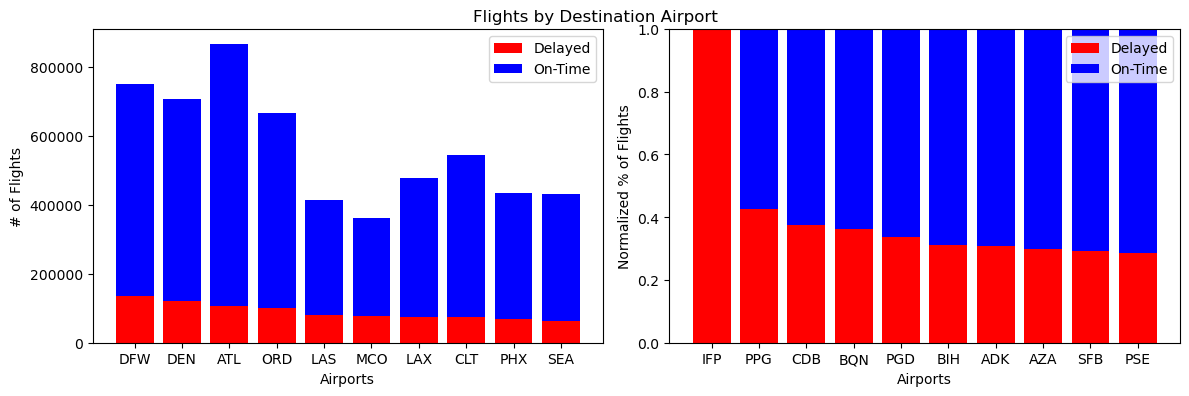

In [192]:
# Cross tab report for Destination Airport
airport_crosstab_df = pd.crosstab(flights_df['Dest'],flights_df['Delayed'])
# Sort by percentage of collissions that result in fatality
airport_crosstab_df.sort_values(airport_crosstab_df.columns[1], ascending = False, inplace=True)
display(airport_crosstab_df)

# Cross tab report for Destination Airport
norm_airport_crosstab_df = pd.crosstab(flights_df['Dest'],flights_df['Delayed'], normalize='index')
norm_airport_crosstab_df.sort_values(norm_airport_crosstab_df.columns[1], ascending = False, inplace=True)
display(norm_airport_crosstab_df)

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(12,4))

# Set Data for Delays by Destination Airport
y1 = airport_crosstab_df[1].head(10)
y2 = airport_crosstab_df[0].head(10)
x = airport_crosstab_df.head(10).index

# Plot Delayed flights by Destination Airport
ax1 = fig.add_subplot(gs[0])
ax1.bar(x, y1, color='r')
ax1.bar(x, y2, bottom=y1, color='b')
ax1.set_xlabel('Airports')
ax1.set_ylabel('# of Flights')
ax1.legend(['Delayed', 'On-Time'])

# Set Data Delayed flights by Normalized Destination Airport data
y1 = norm_airport_crosstab_df[1].head(10)
y2 = norm_airport_crosstab_df[0].head(10)
x = norm_airport_crosstab_df.head(10).index

# Plot Delayed flights by Normalzied Destination Airport data
ax2 = fig.add_subplot(gs[1])
ax2.bar(x, y1, color='r')
ax2.bar(x, y2, bottom=y1, color='b')
ax2.set_xlabel('Airports')
ax2.set_ylabel('Normalized % of Flights')
ax2.legend(['Delayed', 'On-Time'])

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Flights by Destination Airport')
fig.subplots_adjust(top=.93)
plt.show()

In [178]:
# Group flight dataset by Tail_Number
tailnum_df = pd.DataFrame(flights_df.groupby(['Tail_Number', 'FlightDate'])['Tail_Number'].count())
tailnum_df.rename(columns={'Tail_Number': 'Count'}, inplace=True)
tailnum_df = tailnum_df.reset_index()
tailnum_df['Count'].value_counts()

4     1107522
3      734871
2      716861
6      627330
5      578150
1      404807
7      128615
8       79923
9        7867
10       3760
11       1995
12        754
13        204
14          8
Name: Count, dtype: int64

In [316]:
# Final Columns for Modeling
## TODO Add previous flights that day
relevant_columns = ['Month', 'DayofMonth', 'DayOfWeek', 'Carrier',  "Origin", "Dest", "DepTime", "DepDelay", "Delayed",
        'DepTarmacTime', 'ArrTarmacTime','ArrTime','ArrDelay',"AirTime", "Distance", "EmpPerMF"]
final_flight_df = flights_df[relevant_columns]
final_flight_df.head()

,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,DepTime,DepDelay,Delayed,DepTarmacTime,ArrTarmacTime,ArrTime,ArrDelay,AirTime,Distance,EmpPerMF
0,1,17,5,B6,PBI,BDL,1926.0,-14.0,0,15.0,6.0,2218.0,-11.0,151.0,1133.0,0.877219
1,1,18,6,B6,PBI,BDL,1926.0,-14.0,0,14.0,13.0,2220.0,-9.0,147.0,1133.0,0.877219
2,1,19,7,B6,PBI,BDL,1947.0,7.0,0,11.0,6.0,2223.0,-6.0,139.0,1133.0,0.877219
3,1,20,1,B6,PBI,BDL,1933.0,-7.0,0,67.0,13.0,2233.0,4.0,140.0,1133.0,0.877219
4,1,21,2,B6,PBI,BDL,1952.0,12.0,0,50.0,6.0,2235.0,6.0,147.0,1133.0,0.877219


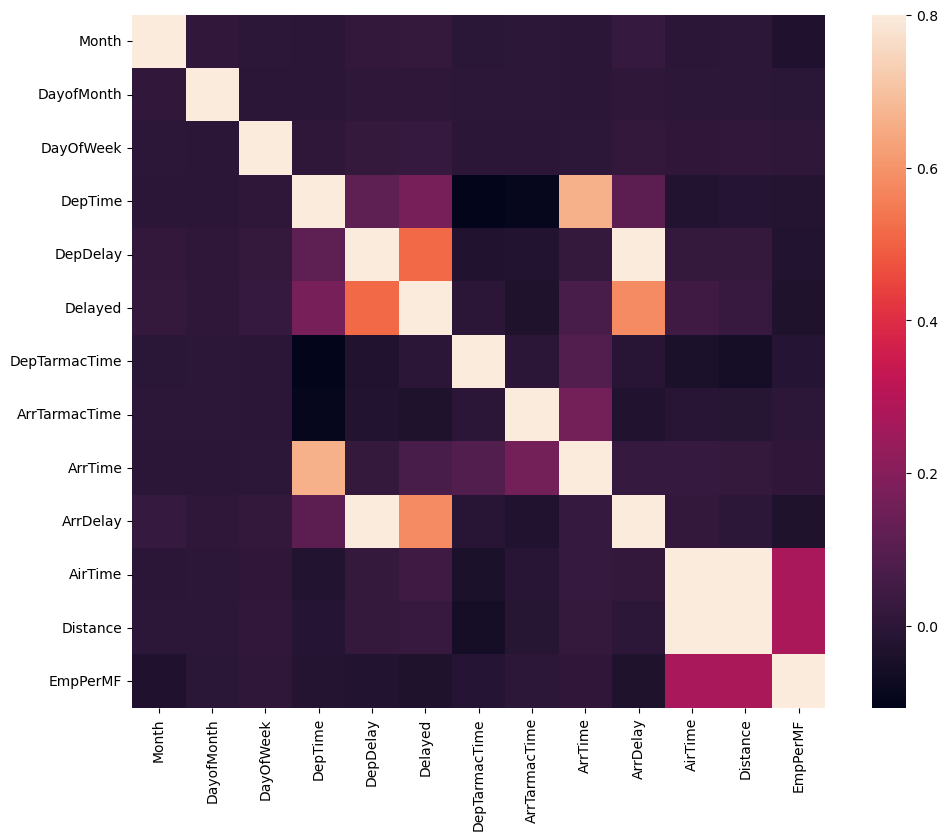

In [317]:
#correlation matrix
corrmat = final_flight_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()